# Supervised-wise FF and Unsupervised-wise FF results with 2000ReLUs per hidden layer

| FF mode | Split mode | validation accuracy |
|---|---|---|
| Unsupervised | Random Splitting | 97.1% |
| Supervised | Random Splitting | 94.7% |
| Supervised | No Splitting | 95.1% |

Hyperparameter tuning to get best accuracy were not done.

## What is split mode?
FF-based learning required both positive data and negative data. To use the dataset for both purposes, each FF-based layer was divided into two halves and the MNIST datasets were split into two sets (A, B). Set A contained five randomly selected digits, and set B contained the rest. The first half layer took set A as positive data, and set B as negative. The second half took set B as positive data, and set A as positive. Two different digit splittings are possible for unsupervised-wise FF: "random splitting" and "same splitting", and an additional "no splitting" can be used for supervised-wise FF.

The random splitting made sure each layer received different sets of positives and negatives, while the same splitting made sure each layer receives the same sets. The no splitting simply didn't split, and use all digits for both positives and negatives, only that this mode is only for supervised-wise FF where the negatives use wrong labels.

For more explanations and discussions, refer to [this article](https://medium.com/@rmwkwok/some-forward-forward-algorithm-experiments-3a9d6f9503b6?source=friends_link&sk=34556e26da24aaa7a7aa5499eff5a993).

# 1. Imports

In [1]:
import sys
sys.path.append('../../ffobjects/')

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from data import create_mnist_datasets
from utils import set_seed, plot_training_curves, get_routes
from trainmgr import TrainMgr
from ffobjects import FFPreNorm, FFSoftmax, FFOverlay, FFGoodness, FFRoutedDense

# CONFIGURATION
NUM_CLASS = 10 # Only digits 0 to 4 are positive samples
IMG_SHAPE = (28, 28, )

# 2. Testbed setup

In [2]:
def create_layers_and_train_seq(units, is_supervised_ff, seed, 
                                route_seed, route_split_mode):
    set_seed(seed=seed)
    
    embedding = tf.reshape(
        tf.one_hot(tf.range(NUM_CLASS), tf.reduce_prod(IMG_SHAPE)), 
        (NUM_CLASS, *IMG_SHAPE))
    
    layers = dict(
        # Utilities
        input = tf.keras.layers.InputLayer(name='input'),
        concat = tf.keras.layers.Concatenate(name='concat'),
        flatten = tf.keras.layers.Flatten(name='flatten'),
        preNorm = FFPreNorm(name='preNorm'),
        overlay = FFOverlay(embedding, name='overlay'),

        # FF layers
        b1 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b1'),
        b2 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b2'),
        b3 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b3'),
        b4 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b4'),

        # Classifiers
        softmax    = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax'),
        goodness   = FFGoodness(name=f'goodness'),
        softmax_b1 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b1'),
        softmax_b2 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b2'),
        softmax_b3 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b3'),
        softmax_b4 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b4'),
    )
    
    ff_layer_names = ['b1', 'b2', 'b3', 'b4']
    routes = get_routes(NUM_CLASS, units, len(ff_layer_names), route_seed, route_split_mode)
    for name, route in zip(ff_layer_names, routes):
        if is_supervised_ff:
            layers[name].ff_set_ctu_map(route, route)
        else:
            layers[name].ff_set_ctu_map(route, 1 - route)
    
    def train_seq(X, y, y_ff):
        x = layers['input'](X)
        if is_supervised_ff:
            x = layers['overlay'].ff_do_task((x, y), None)
        x = layers['flatten'](x)
        b1a = layers['b1'].ff_set_classes(y).ff_do_task(x, y_ff)
        b1n = layers['preNorm'](b1a)
        b2a = layers['b2'].ff_set_classes(y).ff_do_task(b1n, y_ff)
        b2n = layers['preNorm'](b2a)
        b3a = layers['b3'].ff_set_classes(y).ff_do_task(b2n, y_ff)
        b3n = layers['preNorm'](b3a)
        b4a = layers['b4'].ff_set_classes(y).ff_do_task(b3n, y_ff)
        b4n = layers['preNorm'](b4a)
        if is_supervised_ff:
            goodness_x = layers['concat']([b2a, b3a, b4a])
            y_pred = layers['goodness'].ff_do_task(goodness_x, y)
        else:
            softmax_x = layers['concat']([b2n, b3n, b4n])
            y_pred = layers['softmax'].ff_do_task(softmax_x, y)
            
        _ = layers['softmax_b1'].ff_do_task(b1n, y)
        _ = layers['softmax_b2'].ff_do_task(b2n, y)
        _ = layers['softmax_b3'].ff_do_task(b3n, y)
        _ = layers['softmax_b4'].ff_do_task(b4n, y)
        return y_pred
    
    return layers, train_seq

def train_layers(
    units, is_supervised_ff, 
    batch_size, data_shuffle_seed, 
    trainable_layers_list, show_metrics_max,
    route_seed, route_split_mode,
):
    '''
    Refer to the example in the next cell for explanation of arguments.
    '''
    layers, train_seq = create_layers_and_train_seq(
        units=units, 
        seed=300, 
        is_supervised_ff=is_supervised_ff,
        route_seed=route_seed,
        route_split_mode=route_split_mode)
    
    set_seed(seed=300)
    dataset = create_mnist_datasets(
        seed=data_shuffle_seed, 
        batch_size=batch_size, 
        is_supervised_ff=is_supervised_ff)
    train_mgr = TrainMgr(layers, train_seq).ff_train(
        dataset, 
        trainable_layers_list, 
        show_metrics_max=show_metrics_max)
    plot_training_curves(train_mgr)
    
    return train_mgr

# 3. Unsupervised-FF, RandomSplitting

200/200 [==============================] - 16209s 81s/step - b1: 0.0275 - b2: 0.0104 - b3: 0.0289 - b4: 0.0279 - softmax: 0.9707 - softmax_b1: 0.9737 - softmax_b2: 0.9680 - softmax_b3: 0.9690 - softmax_b4: 0.9682 - softmax_b23: 0.9708 - softmax_b34: 0.9686 - softmax_b24: 0.9706 - softmax_b1234: 0.9740 - best_softmax: 0.9711 - best_softmax_b1: 0.9739 - best_softmax_b2: 0.9689 - best_softmax_b3: 0.9690 - best_softmax_b4: 0.9682 - best_softmax_b23: 0.9708 - best_softmax_b34: 0.9690 - best_softmax_b24: 0.9711 - best_softmax_b1234: 0.9740


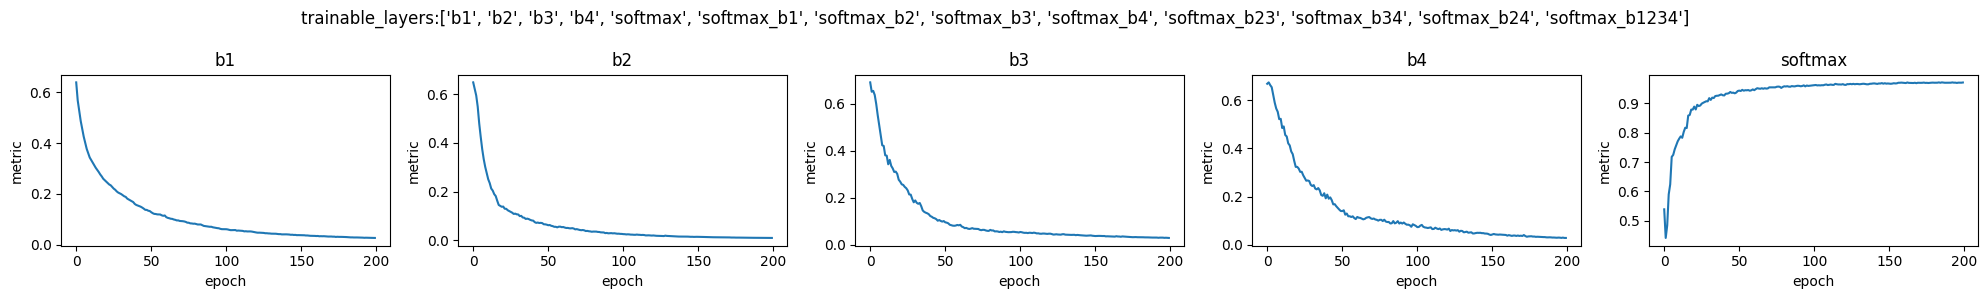

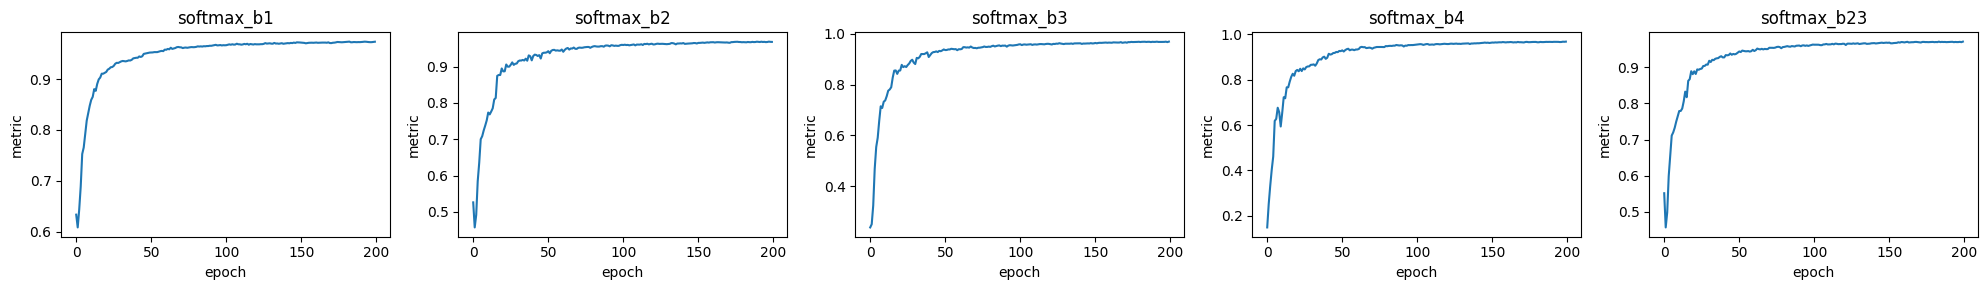

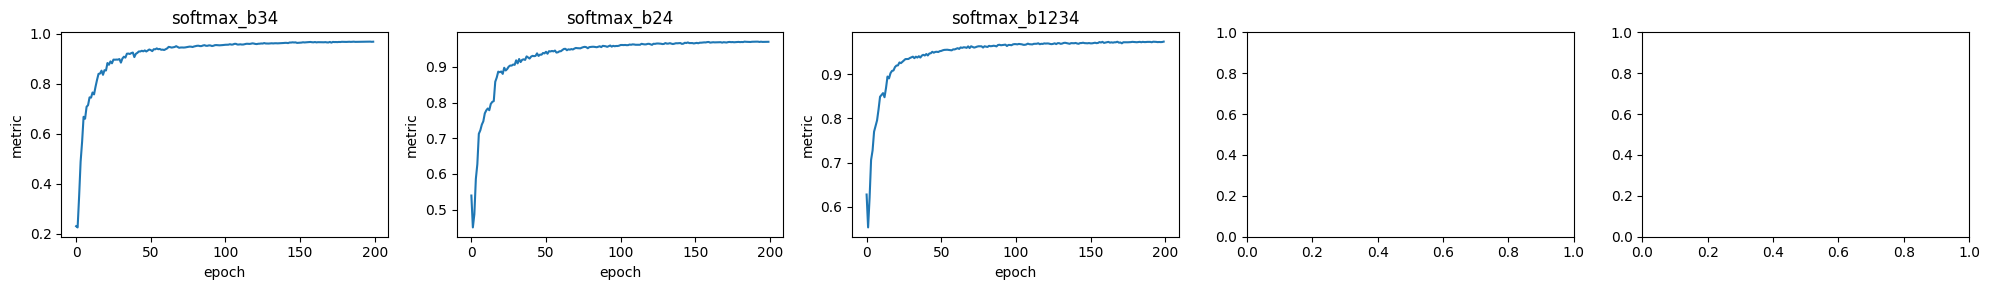

In [3]:
train_mgr0 = train_layers(
    units = 2000,
    is_supervised_ff = False,
    batch_size = 256,
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['b1', 'b2', 'b3', 'b4', 'softmax', 
          'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4',
         ], 200],
    ],
    show_metrics_max = ['softmax', 
                        'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4'],
    route_seed = 0,
    route_split_mode = 'RandomSplitting',
)

# 4. Supervised-wise FF, RandomSplitting

200/200 [==============================] - 10975s 55s/step - b1: 0.0704 - b2: 0.2066 - b3: 0.2527 - b4: 0.2998 - goodness_duped: 0.9451 - softmax_b1: 0.9939 - softmax_b2: 0.9734 - softmax_b3: 0.9494 - softmax_b4: 0.9112 - best_goodness_duped: 0.9477 - best_softmax_b1: 0.9950 - best_softmax_b2: 0.9734 - best_softmax_b3: 0.9582 - best_softmax_b4: 0.9353


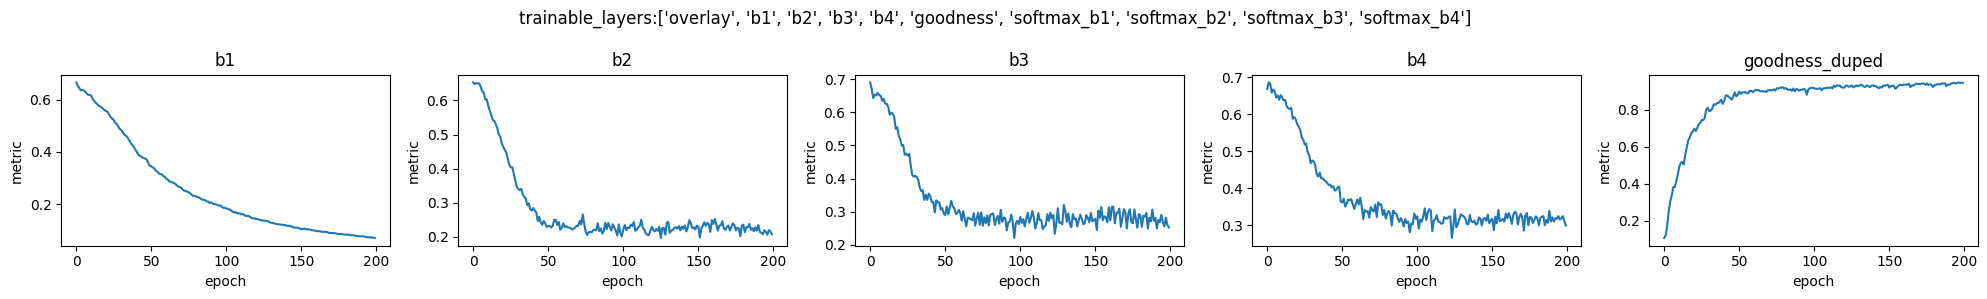

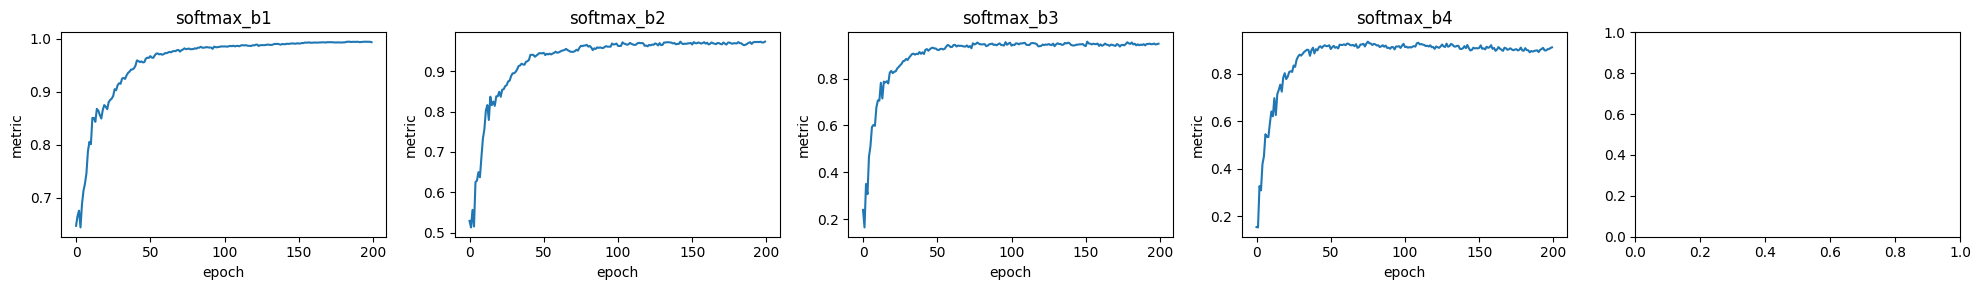

In [4]:
train_mgr0 = train_layers(
    units = 2000, 
    is_supervised_ff = True, #CHANGE
    batch_size = 256,
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', 
          'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4', 
         ], 200],
    ],
    show_metrics_max = ['goodness', 'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4'],
    route_seed = 0,
    route_split_mode = 'RandomSplitting',
)

# 5. Supervised-wise FF, NoSplitting

200/200 [==============================] - 12187s 61s/step - b1: 0.1138 - b2: 0.0891 - b3: 0.1191 - b4: 0.1424 - goodness_duped: 0.9499 - softmax_b1: 0.9907 - softmax_b2: 0.9885 - softmax_b3: 0.9786 - softmax_b4: 0.9682 - best_goodness_duped: 0.9512 - best_softmax_b1: 0.9919 - best_softmax_b2: 0.9896 - best_softmax_b3: 0.9815 - best_softmax_b4: 0.9726


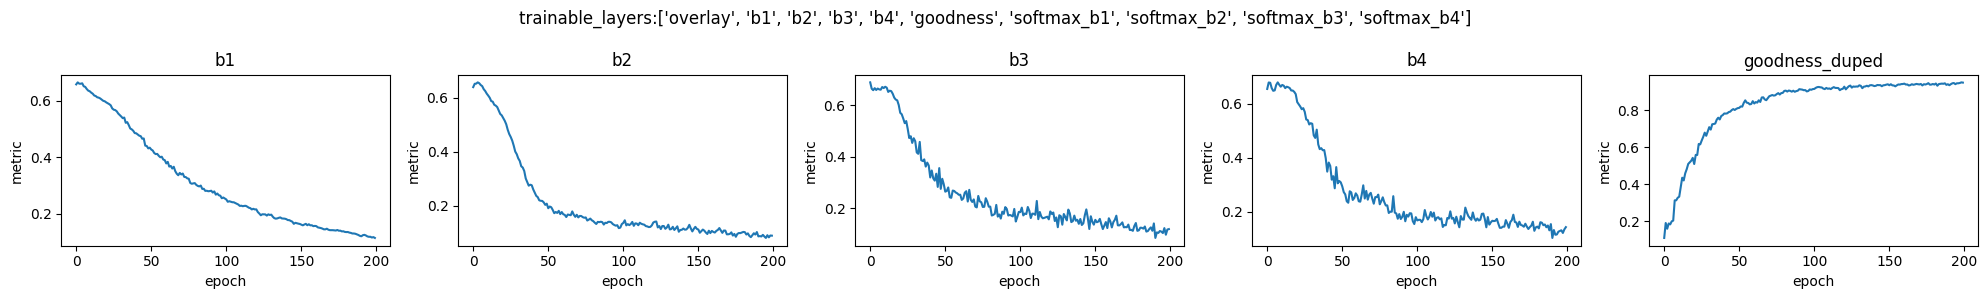

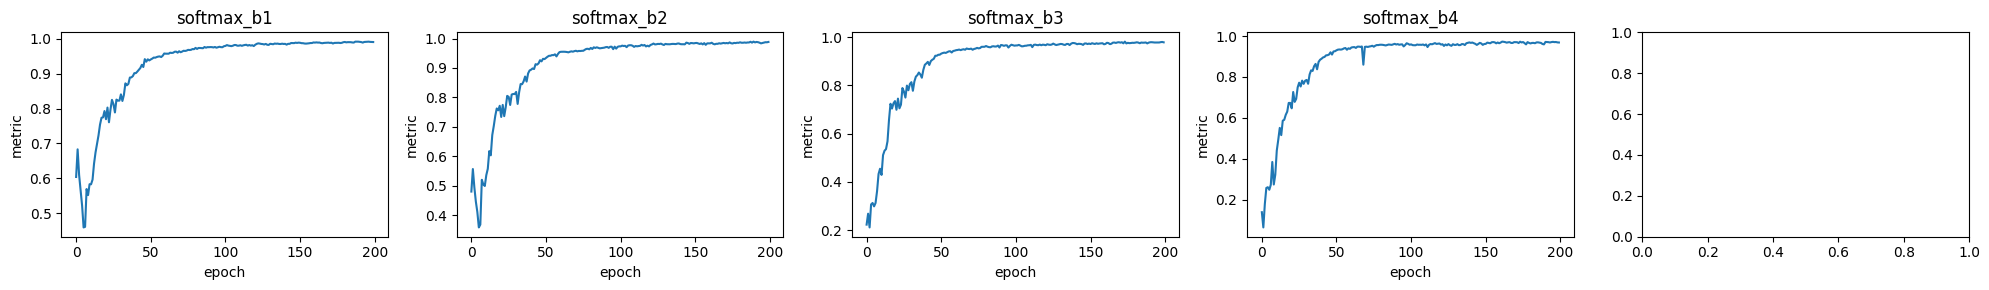

In [5]:
#full
train_mgr0 = train_layers(
    units = 2000,
    is_supervised_ff = True, 
    batch_size = 256,
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', 
          'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4', 
         ], 200],
    ],
    show_metrics_max = ['goodness', 'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4'],
    route_seed = 0,
    route_split_mode = 'NoSplitting', #CHANGE
)